Thinking of APR. Are we doing the dual optimization with the classification model + the pertubation added?

1. Run BPR and retrieve the model parameters + predict with parameters
2. Create input output for adversary and train + save adversary
3. tune data with the discussed methodology

In [2]:
#import relevant library

import math
import os
import random
import pickle
import argparse
from collections import deque
import time
from datetime import timedelta
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
# from torchvision import transforms
from torch.utils.data import IterableDataset, DataLoader, get_worker_info
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [96]:
## time the process
def get_time_dif(start_time):
    """get the running time"""
    end_time = time.time()
    time_dif = end_time - start_time
    return timedelta(seconds=int(round(time_dif)))


## set up the u,i,j triplet for BPR framework
class GetTriplePair(IterableDataset):
    # for ml-1m we load in 3760 item 6040 user and 994169 train pair
    def __init__(self, item_size, user_list, pair, shuffle, num_epochs):
        self.item_size = item_size
        self.user_list = user_list
        self.pair = pair
        self.shuffle = shuffle
        self.num_epochs = num_epochs

    def __iter__(self):
        self.example_size = self.num_epochs * len(self.pair)
        self.example_index_queue = deque([])
        self.seed = 0
        self.start_list_index = None
        self.num_workers = 1
        self.index = 0
        return self

    def __next__(self):
        if self.index >= self.example_size:
            raise StopIteration
        # If `example_index_queue` is used up, replenish this list.
        while len(self.example_index_queue) == 0:
            index_list = list(range(len(self.pair)))
            if self.shuffle:
                random.Random(self.seed).shuffle(index_list)
                self.seed += 1
            if self.start_list_index is not None:
                index_list = index_list[self.start_list_index::self.num_workers]

                # Calculate next start index
                self.start_list_index = (self.start_list_index + (self.num_workers - (len(self.pair) % self.num_workers))) % self.num_workers
            self.example_index_queue.extend(index_list)
        result = self._example(self.example_index_queue.popleft())
        self.index += self.num_workers
        return result

    def _example(self, idx):
        # in a train pair, format = (u,i), j = a random item which does not exist in user u's list of items
        u = self.pair[idx][0]
        i = self.pair[idx][1]
        j = np.random.randint(self.item_size)
        while j in self.user_list[u]:
            j = np.random.randint(self.item_size)
        return u, i, j

## chunk to define matrix factorization part
class MF(nn.Module):
    def __init__(self, user_size, item_size, dim, reg, reg_adv, eps):
        super().__init__()
        ##init the embedding for U and I
        self.W = nn.Parameter(torch.empty(user_size, dim))  # User embedding
        self.H = nn.Parameter(torch.empty(item_size, dim))  # Item embedding
        nn.init.xavier_normal_(self.W.data)
        nn.init.xavier_normal_(self.H.data)
        self.reg = reg
        self.user_size = user_size
        self.item_size = item_size
        self.dim = dim
        self.reg_adv = reg_adv
        self.eps = eps
        self.update_u = None
        self.update_i = None
        self.update_j = None

## forward cal
    def forward(self, u, i, j, epoch):
        """Return loss value.

        Args:
            u(torch.LongTensor): tensor stored user indexes. [batch_size,]
            i(torch.LongTensor): tensor stored item indexes which is prefered by user. [batch_size,]
            j(torch.LongTensor): tensor stored item indexes which is not prefered by user. [batch_size,]
            epoch

        Returns:
            torch.FloatTensor
        """
        ##u,i,j respectively, each is a vector of dim embedding (default = 64)
        u = self.W[u, :]
        i = self.H[i, :]
        j = self.H[j, :]

        ## Enables this Tensor to have their grad populated during backward(), convert any non-leaf tensor into a leaf tensor,
        ##https://stackoverflow.com/questions/73698041/how-retain-grad-in-pytorch-works-i-found-its-position-changes-the-grad-result
        u.retain_grad()
        u_clone = u.data.clone()
        i.retain_grad()
        i_clone = i.data.clone()
        j.retain_grad()
        j_clone = j.data.clone()

        ## mf, dot product of user with pos/neg item
        x_ui = torch.mul(u, i).sum(dim=1)
        x_uj = torch.mul(u, j).sum(dim=1)


        #similar to clip value, find diff between ui and uj
        x_uij =torch.clamp(x_ui - x_uj,min=-80.0,max=1e8)
        #logsigmoid this is equivalent to equation 1 in the paper (classic loss of bpr)
        log_prob = F.logsigmoid(x_uij).sum()
        # regularization = lambda * l2 norm of u, i, j
        regularization = self.reg * (u.norm(dim=1).pow(2).sum() + i.norm(dim=1).pow(2).sum() + j.norm(dim=1).pow(2).sum())

        ## original bpr loss,
        loss = -log_prob + regularization

        loss.backward()
        return loss
        # add adv training after a certain number of epochs, here is the part which we add hypernet module
        if epoch not in range(args.epochs, args.adv_epoch + args.epochs):
            """Normal training"""
            loss.backward()
            return loss

        else:
            """Adversarial training:
                    1.Backward to get grads
                    2.Construct adversarial perturbation
                    3.Add adversarial perturbation to embeddings
                    4.Calculate APR loss
            """
            # Backward to get grads
            # this would be the part we change in defining delta, delta = HPN (phi)

            # should we calculate based on gradient of the adv_loss instead of the loss function?, originally, computed based on loss function
            loss.backward(retain_graph=True) ## need to retain graph here so as to we can backprop the adv_loss
            ##recheck this
            grad_u = u.grad
            grad_i = i.grad
            grad_j = j.grad

            # Construct adversarial perturbation based on gradient of loss function, and normalize it with epsilon * norm
            if grad_u is not None:
                delta_u = nn.functional.normalize(grad_u, p=2, dim=1, eps=self.eps)
            else:
                delta_u = torch.rand(u.size())
            if grad_i is not None:
                delta_i = nn.functional.normalize(grad_i, p=2, dim=1, eps=self.eps)
            else:
                delta_i = torch.rand(i.size())
            if grad_j is not None:
                delta_j = nn.functional.normalize(grad_j, p=2, dim=1, eps=self.eps)
            else:
                delta_j = torch.rand(j.size())

            # Add adversarial perturbation to embeddings, now we have q+delta, p+delta
            x_ui_adv = torch.mul(u + delta_u, i + delta_i).sum(dim=1)
            x_uj_adv = torch.mul(u + delta_u, j + delta_j).sum(dim=1)

            # find difference between pos and neg item, then clip value
            x_uij_adv = torch.clamp(x_ui_adv - x_uj_adv,min=-80.0,max=1e8)

            # Calculate APR loss with logsigmoid
            log_prob = F.logsigmoid(x_uij_adv).sum()
            adv_loss = self.reg_adv *(-log_prob) + loss # this is adversarial loss (equation 4 in paper)
            adv_loss.backward()

            return adv_loss


In [142]:
def evaluate_k(user_emb, item_emb, train_user_list, test_user_list, klist, batch=512):
    """Compute HR and NDCG at k.

    Args:
        user_emb (torch.Tensor): embedding for user [user_num, dim]
        item_emb (torch.Tensor): embedding for item [item_num, dim]
        train_user_list (list(set)):
        test_user_list (list(set)):
        k (list(int)):
    Returns:
        (torch.Tensor, torch.Tensor) HR and NDCG at k
    """

    # Calculate max k value
    max_k = max(klist)
    result = None

    # no iteration = user_num / batch size (which is 512)
    for i in range(0, user_emb.shape[0], batch):

        # Construct mask for each batch

        #new_ones returns a Tensor of size size filled with 1

        # size of the mask vector = (min of batch or user embed) * item+embed
        mask = user_emb.new_ones([min([batch, user_emb.shape[0]-i]), item_emb.shape[0]])
        for j in range(batch):
            if i+j >= user_emb.shape[0]:
                break
            mask[j].scatter_(dim=0, index=torch.tensor(list(train_user_list[i + j])), value=torch.tensor(0.0))

        # Get current result
        cur_result = torch.mm(user_emb[i:i+min(batch, user_emb.shape[0]-i), :], item_emb.t())
        cur_result = torch.sigmoid(cur_result)
        assert not torch.any(torch.isnan(cur_result))

        # Make zero for already observed item
        cur_result = torch.mul(mask, cur_result)
        _, cur_result = torch.topk(cur_result, k=max_k, dim=1)
        result = cur_result if result is None else torch.cat((result, cur_result), dim=0)


    ## basically this chunk collects the results
    result = result.cpu()

    # Sort indice and get HR_NDCG_topk
    HRs, NDCGs = [], []
    for k in klist:
        ndcg, hr = 0, 0
        for i in range(user_emb.shape[0]):
            test = set(test_user_list[i])
            pred = set(result[i, :k].numpy().tolist())
            val = len(test & pred)
            hr += val / max([len(test), 1])
            pred = list(pred)
            x = int(test_user_list[i][0])
            if pred.count(x) != 0:
                position = pred.index(x)
                ndcg += math.log(2) / math.log(position + 2) if position < k else 0
            else:
                ndcg += 0
        NDCGs.append(ndcg / user_emb.shape[0])
        HRs.append(hr / user_emb.shape[0])
        NDCGs.append(ndcg / user_emb.shape[0])
    return HRs, NDCGs


In [151]:
with open('preprocessed/ml-1m.pickle', 'rb') as f:
    dataset = pickle.load(f)
    user_size, item_size = dataset['user_size'], dataset['item_size']
    train_user_list, test_user_list = dataset['train_user_list'], dataset['test_user_list']
    train_pair = dataset['train_pair']

In [152]:
# Create dataset, model, optimizer
dataset = GetTriplePair(item_size, train_user_list, train_pair, True, 1000)

# load batch of 512 item triplets
loader = DataLoader(dataset, batch_size=512)
model = MF(user_size, item_size, 64, 0, 1, 0.5)

In [153]:
optimizer = optim.Adam(model.parameters(), lr=0.00025)

# Training
start_time = time.time()
eval_best_loss = float('inf')

##zero_grad: zeroes the grad attribute of all the parameters passed to the optimizer upon construction
optimizer.zero_grad()
epoch = 0
HR_history = []
NDCG_history = []
# result_history = []
#loader has batch size of 512. In each batch there are 3 tensors of u i j accordingly
for u, i, j in loader:
    if epoch in range(1000):
        loss = model(u, i, j, epoch)

        ##  updates the value of those parameters according to the optimization strategy implemented by the specific optimizer.
        optimizer.step()
        HR_list, NDCG_list = evaluate_k(model.W.detach(),
                                                              model.H.detach(),
                                                              train_user_list,
                                                              test_user_list,
                                                              klist=[50, 100])
        if epoch % 20 == (20- 1):
            if epoch in range(1000):
                print('BPR-MF Epoch [{}/{}]'.format(epoch + 1, 1000))
            print('loss: %.4f' % loss)
            print('HR@50: %.4f, HR@100: %.4f, NDCG@50: %.4f, NDCG@100: %.4f' % (
                HR_list[0], HR_list[1], NDCG_list[0], NDCG_list[1]))
        HR_history.append(HR_list[1])
        NDCG_history.append(NDCG_list[1])
        result_history.append(x_ui)
        if epoch % 100 == 0:
            if loss < eval_best_loss:
                eval_best_loss = loss
                dirname = os.path.dirname(os.path.abspath('output/bpr_manual'))
                os.makedirs(dirname, exist_ok=True)
                torch.save(model.state_dict(), 'output/bpr_manual')
                time_dif = get_time_dif(start_time)
                print("time", time_dif)
        epoch += 1
    else:
        break


time 0:00:00
BPR-MF Epoch [20/1000]
loss: 354.8734
HR@50: 0.0129, HR@100: 0.0253, NDCG@50: 0.0034, NDCG@100: 0.0034
BPR-MF Epoch [40/1000]
loss: 354.8360
HR@50: 0.0136, HR@100: 0.0270, NDCG@50: 0.0036, NDCG@100: 0.0036
BPR-MF Epoch [60/1000]
loss: 354.7814
HR@50: 0.0129, HR@100: 0.0268, NDCG@50: 0.0034, NDCG@100: 0.0034
BPR-MF Epoch [80/1000]
loss: 354.8746
HR@50: 0.0127, HR@100: 0.0260, NDCG@50: 0.0034, NDCG@100: 0.0034
BPR-MF Epoch [100/1000]
loss: 354.7429
HR@50: 0.0131, HR@100: 0.0270, NDCG@50: 0.0036, NDCG@100: 0.0036
time 0:00:23
BPR-MF Epoch [120/1000]
loss: 355.0590
HR@50: 0.0146, HR@100: 0.0296, NDCG@50: 0.0037, NDCG@100: 0.0037
BPR-MF Epoch [140/1000]
loss: 354.8077
HR@50: 0.0147, HR@100: 0.0331, NDCG@50: 0.0037, NDCG@100: 0.0037
BPR-MF Epoch [160/1000]
loss: 354.7373
HR@50: 0.0180, HR@100: 0.0353, NDCG@50: 0.0046, NDCG@100: 0.0046
BPR-MF Epoch [180/1000]
loss: 353.9389
HR@50: 0.0204, HR@100: 0.0377, NDCG@50: 0.0053, NDCG@100: 0.0053
BPR-MF Epoch [200/1000]
loss: 353.6233
HR@

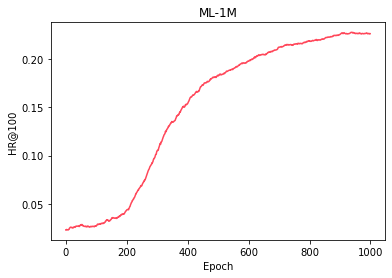

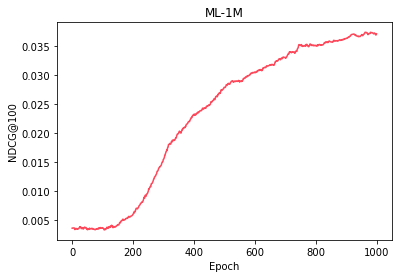

In [154]:
fig_HR = plt.figure(edgecolor='blue')
ax1 = fig_HR.add_subplot(111)
plt.ylabel('HR@100')
plt.xlabel('Epoch')
plt.title('ML-1M')
ax1.plot(range(len(HR_history)), HR_history, c=np.array([255, 71, 90]) / 255.)
plt.show()
fig_P = plt.figure(edgecolor='blue')
ax1 = fig_P.add_subplot(111)
plt.ylabel('NDCG@100')
plt.xlabel('Epoch')
plt.title('ML-1M')
ax1.plot(range(len(NDCG_history)), NDCG_history, c=np.array([255, 71, 90]) / 255.)
plt.show()

In [103]:
for u, i, j in loader:
    if epoch in range(1000):
        x_ui = torch.mul(list(model1.items())[0][1][u], list(model1.items())[1][1][i]).sum(dim=1)
        x_uj = torch.mul(list(model1.items())[0][1][u], list(model1.items())[1][1][j]).sum(dim=1)
        input_to_adv = torch.cat((x_ui, x_uj), 0)

KeyboardInterrupt: 

In [120]:
user_size, item_size 
train_user_list, test_user_list
train_pair 

[(0, 32),
 (0, 34),
 (0, 4),
 (0, 35),
 (0, 30),
 (0, 29),
 (0, 33),
 (0, 40),
 (0, 10),
 (0, 16),
 (0, 23),
 (0, 28),
 (0, 12),
 (0, 8),
 (0, 5),
 (0, 20),
 (0, 46),
 (0, 15),
 (0, 50),
 (0, 49),
 (0, 13),
 (0, 1),
 (0, 52),
 (0, 38),
 (0, 19),
 (0, 6),
 (0, 2),
 (0, 26),
 (0, 17),
 (0, 39),
 (0, 45),
 (0, 42),
 (0, 14),
 (0, 11),
 (0, 18),
 (0, 48),
 (0, 41),
 (0, 43),
 (0, 51),
 (0, 9),
 (0, 44),
 (0, 21),
 (0, 0),
 (0, 47),
 (0, 7),
 (0, 3),
 (0, 36),
 (0, 24),
 (0, 22),
 (0, 37),
 (0, 27),
 (0, 31),
 (1, 86),
 (1, 66),
 (1, 72),
 (1, 130),
 (1, 73),
 (1, 79),
 (1, 126),
 (1, 163),
 (1, 91),
 (1, 98),
 (1, 60),
 (1, 137),
 (1, 107),
 (1, 118),
 (1, 154),
 (1, 146),
 (1, 69),
 (1, 74),
 (1, 83),
 (1, 160),
 (1, 157),
 (1, 94),
 (1, 65),
 (1, 125),
 (1, 119),
 (1, 58),
 (1, 122),
 (1, 117),
 (1, 93),
 (1, 120),
 (1, 166),
 (1, 150),
 (1, 155),
 (1, 90),
 (1, 145),
 (1, 110),
 (1, 78),
 (1, 113),
 (1, 62),
 (1, 156),
 (1, 148),
 (1, 144),
 (1, 97),
 (1, 48),
 (1, 151),
 (1, 132),
 (1,

[208]

In [43]:


#load the results of BPR
model1 = (torch.load('output/bpr_manual'))
list(model1.items())[0].size()



OrderedDict([('W',
              tensor([[-0.2709,  0.0240, -0.2694,  ...,  0.3150,  0.3628, -0.2702],
                      [-0.2629,  0.2788, -0.2968,  ...,  0.3980,  0.1637, -0.0974],
                      [-0.5746, -0.0472, -0.0899,  ...,  0.4875,  0.1219, -0.5187],
                      ...,
                      [ 0.1688,  0.1936,  0.2084,  ...,  0.2003,  0.2031, -0.4268],
                      [-0.3675, -0.0132, -0.3530,  ...,  0.2202,  0.0546, -0.2679],
                      [ 0.3161, -0.1737, -0.4435,  ...,  0.1765, -0.0140, -0.2318]])),
             ('H',
              tensor([[-0.2399,  0.1708, -0.1821,  ...,  0.2063,  0.3038, -0.3121],
                      [-0.0382,  0.2766,  0.1841,  ...,  0.0606,  0.2054, -0.1138],
                      [-0.2020, -0.0848, -0.4983,  ...,  0.2910,  0.1679, -0.2490],
                      ...,
                      [ 0.5427,  0.4184,  0.4959,  ..., -0.5348, -0.3872,  0.5943],
                      [ 0.4566,  0.5307,  0.6051,  ..., -0.5392, 

In [102]:
torch.mul(list(model1.items())[0][1][0], list(model1.items())[1][1][3]).sum(dim=1)

tensor(2.9820)

In [63]:
list(model1.items())[0][1][0]

tensor([-0.2709,  0.0240, -0.2694,  0.1702,  0.0666, -0.3813,  0.2742, -0.2301,
         0.3887,  0.2617,  0.0406,  0.0489, -0.2536,  0.1961,  0.3255,  0.2506,
        -0.2629,  0.3150,  0.2808,  0.2173,  0.1912, -0.1766,  0.0713, -0.2156,
         0.2328,  0.3876, -0.2384,  0.4047, -0.5163, -0.1535, -0.1244, -0.3184,
        -0.0359, -0.3803,  0.2953, -0.2314, -0.2500,  0.1305, -0.4383,  0.2056,
        -0.4615,  0.4404, -0.3453,  0.1605, -0.3945, -0.5250,  0.2686,  0.2457,
        -0.1573, -0.1325, -0.1725, -0.4593, -0.1533, -0.4240,  0.2936,  0.0894,
        -0.3135,  0.3907, -0.3876,  0.1731,  0.3529,  0.3150,  0.3628, -0.2702])

In [51]:
list(model1.items())[1][1][0]

tensor([-0.2399,  0.1708, -0.1821,  0.3227, -0.0651, -0.3684,  0.2576, -0.0967,
         0.2727,  0.2429, -0.2924,  0.0085, -0.1224, -0.3993,  0.1339,  0.2115,
        -0.3123,  0.3728,  0.2831,  0.3135,  0.2664, -0.2123, -0.2347, -0.2341,
         0.2848, -0.0380, -0.2045,  0.2214, -0.2320, -0.2688, -0.1562,  0.5387,
        -0.2084, -0.2278, -0.2945, -0.2160, -0.3322,  0.2095,  0.0394,  0.0138,
        -0.2676,  0.1160, -0.2515,  0.1762, -0.2421, -0.3025,  0.2232, -0.1739,
         0.2366, -0.2195, -0.2256, -0.1874, -0.2779, -0.2359,  0.3354, -0.0124,
        -0.2896,  0.3191, -0.1170,  0.1857,  0.2776,  0.2063,  0.3038, -0.3121])

In [ ]:
#adv, linear-relu, linear-sigmoid last layer, numlayer = 4, 512,256,128,64 hidden units 

adversary = nn.Sequential(
    nn.Linear(764, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.Sigmoid()
)